# PRASUNET Internship

# TASK-04

Analyze and visualize sentiment patterns in social media data to understand public opinion and attitudes towards specific topics or brands.

# Data Overview
### Training Data

Shape: 74,681 rows × 4 columns

Columns:

Column 0: An identifier (repeated value "2401")

Column 1: Topic (e.g., "Borderlands")

Column 2: Sentiment (e.g., "Positive")

Column 3: Text (e.g., "I'm getting on borderlands and I will murder you all")

### Validation Data

Shape: 999 rows × 4 columns

Columns:

Column 0: An identifier (various values like "3364")

Column 1: Topic (e.g., "Facebook")

Column 2: Sentiment (e.g., "Irrelevant")

Column 3: Text (e.g., "I mentioned on Facebook that I was struggling...")

# Import Libraries

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer 
import re

In [2]:
# Download NLTK resources
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\siyam\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\siyam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\siyam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#  Load and Clean Data

In [3]:
# Load the datasets
training_data_path = 'D:/Internship/Prasunet/Task 4/twitter_training.csv'
validation_data_path = 'D:/Internship/Prasunet/Task 4/twitter_validation.csv'

# Reading the datasets
training_data = pd.read_csv(training_data_path)
validation_data = pd.read_csv(validation_data_path)

# Display the first few rows of each dataset to understand the structure
training_data_info = training_data.head()
validation_data_info = validation_data.head()

training_data_info, training_data.shape, validation_data_info, validation_data.shape


(   2401  Borderlands  Positive  \
 0  2401  Borderlands  Positive   
 1  2401  Borderlands  Positive   
 2  2401  Borderlands  Positive   
 3  2401  Borderlands  Positive   
 4  2401  Borderlands  Positive   
 
   im getting on borderlands and i will murder you all ,  
 0  I am coming to the borders and I will kill you...     
 1  im getting on borderlands and i will kill you ...     
 2  im coming on borderlands and i will murder you...     
 3  im getting on borderlands 2 and i will murder ...     
 4  im getting into borderlands and i can murder y...     ,
 (74681, 4),
    3364   Facebook Irrelevant  \
 0   352     Amazon    Neutral   
 1  8312  Microsoft   Negative   
 2  4371      CS-GO   Negative   
 3  4433     Google    Neutral   
 4  6273       FIFA   Negative   
 
   I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now think

In [4]:
# Renaming columns for clarity
training_data.columns = ['ID', 'Topic', 'Sentiment', 'Text']
validation_data.columns = ['ID', 'Topic', 'Sentiment', 'Text']

# Drop the 'ID' column since it doesn't add value for sentiment analysis
training_data.drop('ID', axis=1, inplace=True)
validation_data.drop('ID', axis=1, inplace=True)

# Check for missing values
training_missing_values = training_data.isnull().sum()
validation_missing_values = validation_data.isnull().sum()

training_missing_values, validation_missing_values

(Topic          0
 Sentiment      0
 Text         686
 dtype: int64,
 Topic        0
 Sentiment    0
 Text         0
 dtype: int64)

### Missing Values:

Training Data: 686 missing values in the Text column.

Validation Data: No missing values.

We'll handle the missing values in the training data by removing the rows with missing text since they cannot contribute to sentiment analysis.

In [5]:
# Drop rows with missing 'Text' in the training data
training_data_cleaned = training_data.dropna(subset=['Text'])

# Verify the cleaning
training_data_cleaned.shape, training_data_cleaned.isnull().sum()

((73995, 3),
 Topic        0
 Sentiment    0
 Text         0
 dtype: int64)

# Preprocessing the text data

In [6]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    #convert to lowercase
    text = text.lower()
    
    #remove numbers and special charaters
    text = re.sub(r'\d+', ' ',text)
    text = re.sub(r'[^a-zA-Z\s]', ' ',text)
    
    #tokenize the text
    tokens = nltk.word_tokenize(text)
   
    #remove stoke words
    tokens= [token for token in tokens if token not in stop_words]
    
    #lemmatize tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    #join tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

The `preprocess_text` function prepares text data for sentiment analysis by applying several preprocessing steps:

1. **Lowercasing**: Converts all text to lowercase to ensure uniformity in word representation.

2. **Removing Numbers and Special Characters**: Eliminates numerical digits and non-alphabetic characters from the text, which are typically irrelevant for sentiment analysis.

3. **Tokenization**: Splits the text into individual tokens (words) to facilitate further analysis.

4. **Stopword Removal**: Filters out common English stopwords (e.g., "the", "and", "is") that do not carry significant meaning for sentiment analysis.

5. **Lemmatization**: Reduces words to their base or root form (lemmas) to normalize variations of the same word (e.g., "running" to "run").

6. **Joining Tokens**: Reconstructs the processed tokens back into a single string, ready for sentiment scoring and analysis.

This function standardizes and refines the text data, removing noise (like numbers and special characters), reducing variation (via lemmatization), and eliminating non-informative words (stopwords). It prepares the text optimally for sentiment analysis, ensuring that the analysis focuses on meaningful linguistic patterns.

# Sentiment Analysis

In [7]:
# Initialize Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()

# Function to get sentiment score
def get_sentiment_score(text):
    return sid.polarity_scores(text)['compound']

# Apply sentiment analysis to the processed text
training_data_cleaned['Sentiment_Score'] = training_data_cleaned['Text'].apply(get_sentiment_score)

# Classify sentiment based on score
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply classification
training_data_cleaned['Predicted_Sentiment'] = training_data_cleaned['Sentiment_Score'].apply(classify_sentiment)

C:\Users\siyam\AppData\Local\Temp\ipykernel_9128\1316547299.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_cleaned['Sentiment_Score'] = training_data_cleaned['Text'].apply(get_sentiment_score)
C:\Users\siyam\AppData\Local\Temp\ipykernel_9128\1316547299.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_cleaned['Predicted_Sentiment'] = training_data_cleaned['Sentiment_Score'].apply(classify_sentiment)


The sentiment analysis code utilizes the VADER (Valence Aware Dictionary and sEntiment Reasoner) tool to assess sentiment intensity in the processed text data.

1. **Initialization and Setup**: 
   - **Initialize Sentiment Intensity Analyzer**: `sid = SentimentIntensityAnalyzer()` sets up the analyzer to evaluate sentiment scores based on lexicon and rule-based analysis.

2. **Sentiment Scoring**: 
   - **Function to Get Sentiment Score**: `get_sentiment_score(text)` computes a sentiment score (compound score) for each text using VADER's polarity_scores method.

3. **Sentiment Classification**: 
   - **Function to Classify Sentiment**: `classify_sentiment(score)` categorizes sentiment scores into Positive, Negative, or Neutral based on predefined thresholds.
   - **Application**: `training_data_cleaned['Predicted_Sentiment'] = training_data_cleaned['Sentiment_Score'].apply(classify_sentiment)` assigns sentiment classifications to each tweet based on its sentiment score.

The code initializes VADER for sentiment analysis, computes sentiment scores for each tweet, and classifies them into Positive, Negative, or Neutral categories. This approach provides a quantitative assessment of sentiment across the dataset, enabling insights into public sentiment towards various topics or brands.

# Visualization

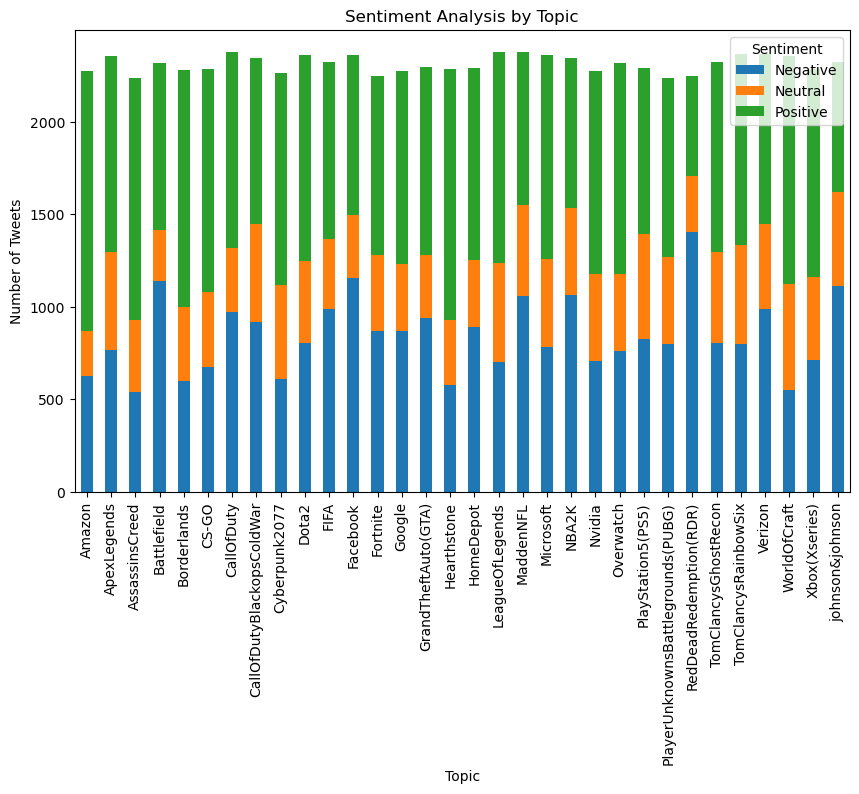

In [8]:
# Count the number of sentiments for each topic
sentiment_counts = training_data_cleaned.groupby(['Topic', 'Predicted_Sentiment']).size().unstack()

# Plot stacked bar chart
sentiment_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sentiment Analysis by Topic')
plt.xlabel('Topic')
plt.ylabel('Number of Tweets')
plt.legend(title='Sentiment')
plt.show()

The stacked bar chart visualizes the distribution of sentiment across different topics in the training data. Each bar represents a specific topic, segmented into Positive, Negative, and Neutral sentiments. This visualization helps in understanding how sentiments vary across various discussions or subjects.

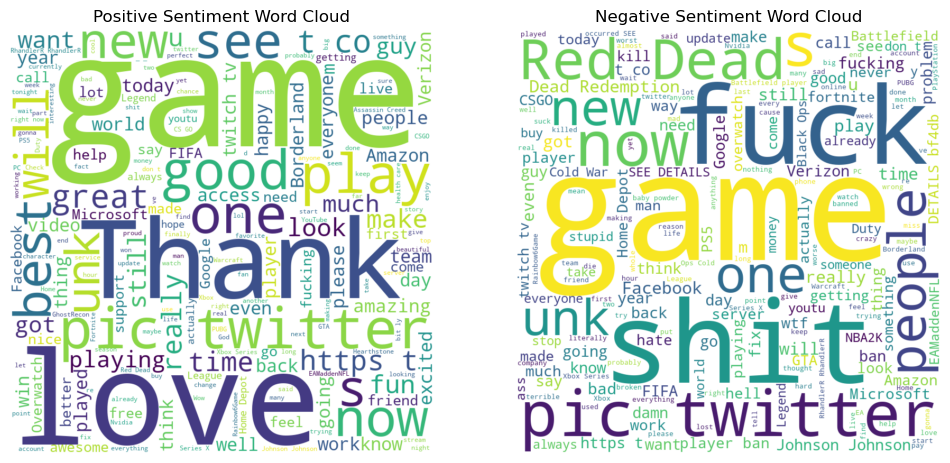

In [9]:
# Create word cloud for each sentiment category
positive_texts = ' '.join(training_data_cleaned[training_data_cleaned['Predicted_Sentiment'] == 'Positive']['Text'])
negative_texts = ' '.join(training_data_cleaned[training_data_cleaned['Predicted_Sentiment'] == 'Negative']['Text'])

# Plot word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
wc_positive = WordCloud(width=800, height=800, background_color='white').generate(positive_texts)
plt.imshow(wc_positive, interpolation='bilinear')
plt.title('Positive Sentiment Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
wc_negative = WordCloud(width=800, height=800, background_color='white').generate(negative_texts)
plt.imshow(wc_negative, interpolation='bilinear')
plt.title('Negative Sentiment Word Cloud')
plt.axis('off')

plt.show()

The word clouds provide a visual representation of the most frequent words associated with positive and negative sentiments in the training data. These word clouds help identify the predominant themes or topics that drive positive or negative opinions in social media discussions related to the analyzed topics.

# Insight 
By integrating sentiment analysis with visualization techniques like stacked bar charts and word clouds, the code facilitates a nuanced understanding of public sentiment and attitudes towards specific topics or brands. 

This approach allows for several key insights:

1. By integrating sentiment analysis with visualization techniques like stacked bar charts and word clouds, the code facilitates a nuanced understanding of public sentiment and attitudes towards specific topics or brands. 


2. Examining word clouds helps uncover specific issues or attributes that resonate positively or negatively with the audience, offering actionable insights for strategic adjustments or communications.


3. Organizations can gain a nuanced understanding of how public sentiment evolves across different topics or over time, guiding proactive responses and targeted engagement strategies.


4. This analytical framework empowers decision-makers to align their actions with public sentiment dynamics, fostering stronger relationships and more effective communication with their audience.